# Tobacco Use and Mortality Prediction 

**Project Objective:** Predict the mortality rate based on tobacco use patterns and related factors from 2004-2014.

This notebook will walk through the following steps:
1.  **Setup:** Install necessary libraries and understanding data.
2.  **Data Loading and Cleaning:** Load the 5 separate CSV files and prepare them for analysis.
3.  **Data Merging:** Combine the cleaned datasets into a single master DataFrame.
4.  **Exploratory Data Analysis (EDA):** Visualize key trends and relationships to build a narrative.
5.  **Modeling with Feature Selection & Tuning:** Build and evaluate four regression models using a curated feature set and hyperparameter tuning to achieve the best possible performance.

### step 1 - has been done in data_undertanding noteboook

### Step 2: Load and Prepare the Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load all five datasets
print("Loading datasets...")
# IMPORTANT: Make sure these CSV files are in the same directory as your notebook!
admissions = pd.read_csv('admissions.csv')
fatalities = pd.read_csv('fatalities.csv')
metrics = pd.read_csv('metrics.csv')
prescriptions = pd.read_csv('prescriptions.csv')
smokers = pd.read_csv('smokers.csv')


Loading datasets...


In [10]:
# --- Data Cleaning ---

def clean_and_convert_to_numeric(df, numeric_cols):
    """Converts specified columns in a DataFrame to numeric types."""
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

print("Converting data types to numeric...")

# Define which columns should be numeric for each dataset
admissions_numeric_cols = ['Value']
fatalities_numeric_cols = ['Value']
smokers_numeric_cols = ['16 and Over', '16-24', '25-34', '35-49', '50-59', '60 and Over']
prescriptions_numeric_cols = prescriptions.columns.drop('Year') # All columns except 'Year'
metrics_numeric_cols = metrics.columns.drop('Year') # All columns except 'Year'

# Apply the function to each dataframe
admissions = clean_and_convert_to_numeric(admissions, admissions_numeric_cols)
fatalities = clean_and_convert_to_numeric(fatalities, fatalities_numeric_cols)
smokers = clean_and_convert_to_numeric(smokers, smokers_numeric_cols)
prescriptions = clean_and_convert_to_numeric(prescriptions, prescriptions_numeric_cols)
metrics = clean_and_convert_to_numeric(metrics, metrics_numeric_cols)

# 1. Clean 'Year' columns to a consistent 'YYYY' integer format.
print("Cleaning 'Year' columns...")
admissions['Year'] = admissions['Year'].str.slice(0, 4).astype(int)
prescriptions['Year'] = prescriptions['Year'].str.slice(0, 4).astype(int)
fatalities['Year'] = fatalities['Year'].astype(int)

# 2. Clean column names in the 'metrics' dataframe for easier access.
print("Cleaning column names in 'metrics' data...")
metrics.columns = metrics.columns.str.replace('\n', ' ').str.replace('  ', ' ')
metrics.rename(columns={
    'Tobacco Price Index': 'Tobacco_Price_Index',
    'Retail Prices Index': 'Retail_Prices_Index',
    'Tobacco Price Index Relative to Retail Price Index': 'Tobacco_Price_Index_Relative_to_Retail',
    "Real Households' Disposable Income": 'Real_Disposable_Income',
    'Affordability of Tobacco Index': 'Affordability_of_Tobacco_Index',
    'Household Expenditure on Tobacco': 'Household_Expenditure_on_Tobacco',
    'Household Expenditure Total': 'Household_Expenditure_Total',
    'Expenditure on Tobacco as a Percentage of Expenditure': 'Expenditure_on_Tobacco_as_Percentage'
}, inplace=True)

print("Data cleaning and type conversion complete.")

Converting data types to numeric...
Cleaning 'Year' columns...
Cleaning column names in 'metrics' data...
Data cleaning and type conversion complete.


### Step 3: Aggregate and Merge Datasets

In [11]:
# --- Filter and Aggregate Data ---

# 1. Get total annual admissions for smoking-related diseases
admissions_total = admissions[
    (admissions['ICD10 Diagnosis'] == 'All diseases which can be caused by smoking') &
    (admissions['Metric'] == 'Number of admissions') &
    (admissions['Sex'].isnull()) # .isnull() on Sex column gets the overall total
].rename(columns={'Value': 'Total_Admissions'})[['Year', 'Total_Admissions']]

# 2. Get total annual fatalities from smoking-related diseases
fatalities_total = fatalities[
    (fatalities['ICD10 Diagnosis'] == 'All deaths which can be caused by smoking') &
    (fatalities['Metric'] == 'Number of observed deaths') &
    (fatalities['Sex'].isnull())
].rename(columns={'Value': 'Total_Fatalities'})[['Year', 'Total_Fatalities']]

# 3. Get the overall smoker percentage for ages 16 and over
smokers_total = smokers[
    (smokers['Sex'].isnull())
].rename(columns={'16 and Over': 'Smoker_Percentage'})[['Year', 'Smoker_Percentage']]

# --- Merge DataFrames ---

# We will merge data from 2004 to 2014, as this is the complete range for fatalities.
years = pd.DataFrame({'Year': range(2004, 2015)})

df = pd.merge(years, metrics, on='Year', how='left')
df = pd.merge(df, smokers_total, on='Year', how='left')
df = pd.merge(df, admissions_total, on='Year', how='left')
df = pd.merge(df, fatalities_total, on='Year', how='left')
df = pd.merge(df, prescriptions, on='Year', how='left')

# --- Create Target Variable ---
df['Mortality_Rate'] = (df['Total_Fatalities'] / df['Total_Admissions']) * 1000

# Drop rows with any missing values before proceeding to EDA and modeling
df.dropna(inplace=True)


display(df.head())

,Year,Tobacco_Price_Index,Retail_Prices_Index,Tobacco_Price_Index_Relative_to_Retail,Real_Disposable_Income,Affordability_of_Tobacco_Index,Household_Expenditure_on_Tobacco,Household_Expenditure_Total,Expenditure_on_Tobacco_as_Percentage,Smoker_Percentage,...,Total_Fatalities,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Bupropion (Zyban) Prescriptions,Varenicline (Champix) Prescriptions,Net Ingredient Cost of All Pharmacotherapies,Net Ingredient Cost of Nicotine Replacement Therapies (NRT),Net Ingredient Cost of Bupropion (Zyban),Net Ingredient Cost of Varenicline (Champix),Mortality_Rate
2,2006,713.7,296.4,240.8,192.3,79.9,15542.0,851456.0,1.8,22,...,271775.0,2079,1938,119,22.0,44817,39743,4315,760.0,190.446926
3,2007,751.5,309.1,243.1,195.9,80.6,15766.0,898478.0,1.8,21,...,267180.0,2475,1756,107,612.0,61479,35883,3882,21714.0,185.696285
4,2008,784.7,321.3,244.2,192.5,78.8,15879.0,928265.0,1.7,21,...,267551.0,2263,1492,58,714.0,57520,30683,2143,24694.0,179.294886
5,2009,815.9,319.7,255.2,195.7,76.7,16209.0,911665.0,1.8,21,...,255801.0,2483,1559,47,877.0,63425,31429,2060,29936.0,171.277229
6,2010,878.3,334.5,262.6,195.0,74.3,17176.0,954781.0,1.8,20,...,252507.0,2564,1541,36,987.0,65883,30808,1581,33494.0,164.588026


### Step 4: Exploratory Data Analysis (EDA)

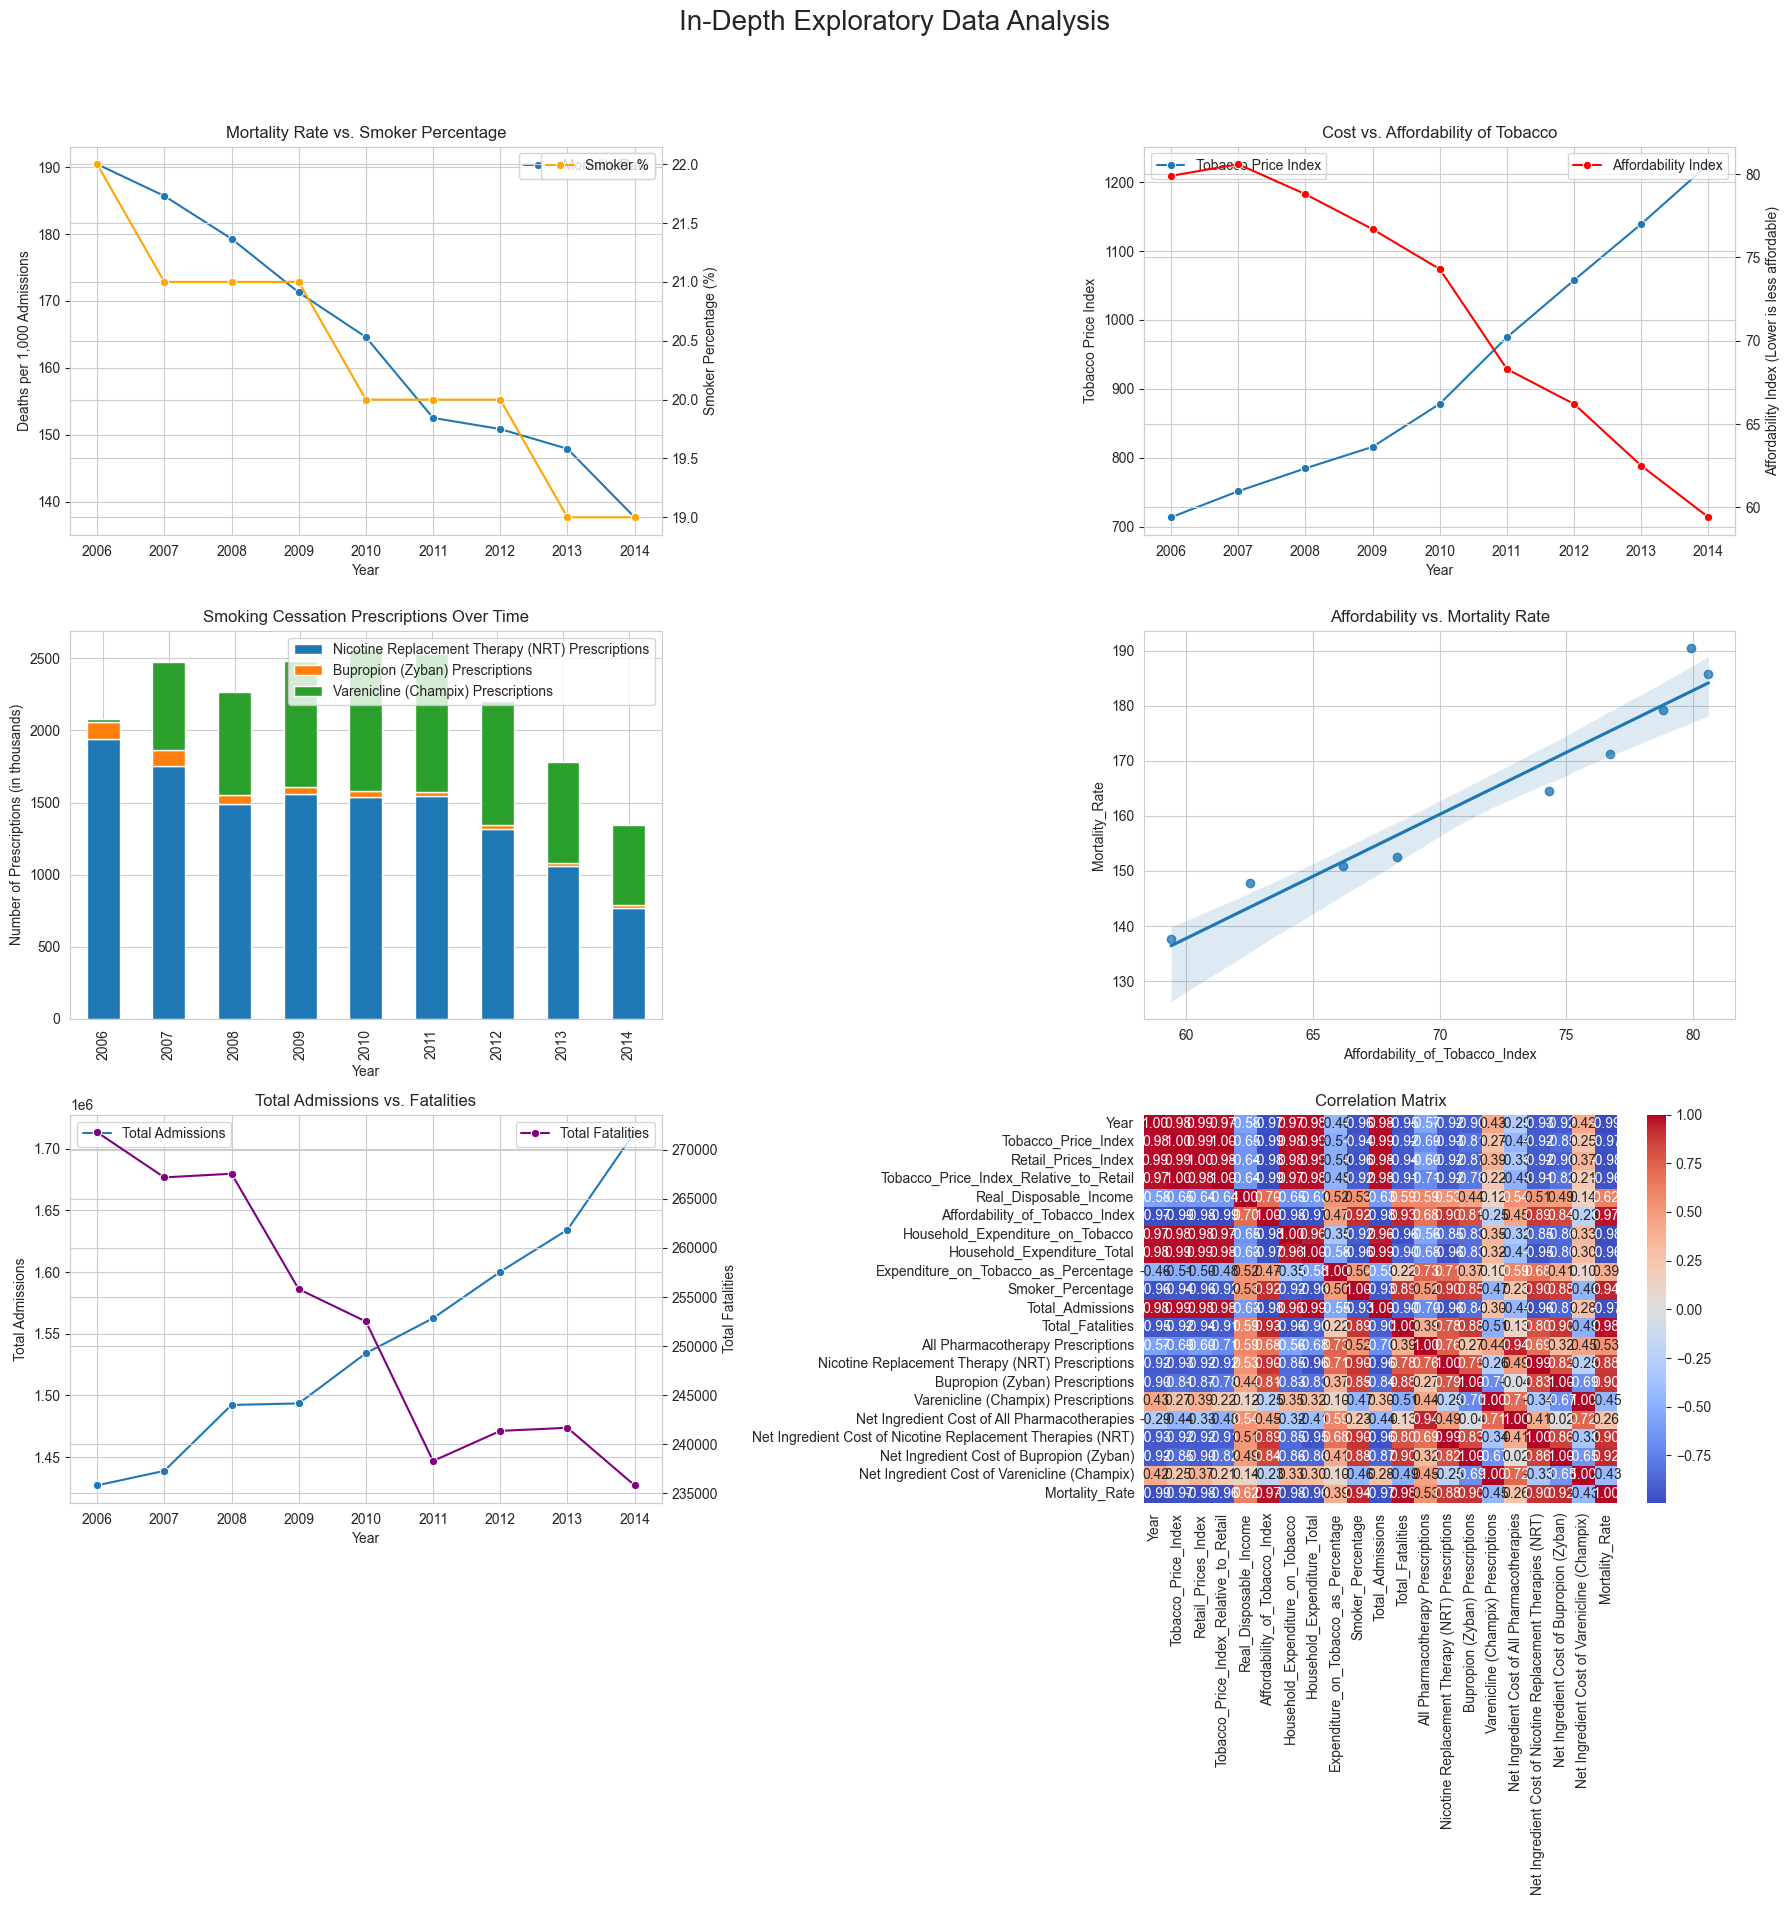

In [12]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.suptitle('In-Depth Exploratory Data Analysis', fontsize=20)

# Plot 1: Mortality Rate vs. Smoker Percentage
sns.lineplot(ax=axes[0, 0], x='Year', y='Mortality_Rate', data=df, marker='o', label='Mortality Rate')
ax2 = axes[0, 0].twinx()
sns.lineplot(ax=ax2, x='Year', y='Smoker_Percentage', data=df, marker='o', color='orange', label='Smoker %')
axes[0, 0].set_title('Mortality Rate vs. Smoker Percentage')
axes[0, 0].set_ylabel('Deaths per 1,000 Admissions')
ax2.set_ylabel('Smoker Percentage (%)')

# Plot 2: Cost vs. Affordability of Tobacco
sns.lineplot(ax=axes[0, 1], x='Year', y='Tobacco_Price_Index', data=df, marker='o', label='Tobacco Price Index')
ax3 = axes[0, 1].twinx()
sns.lineplot(ax=ax3, x='Year', y='Affordability_of_Tobacco_Index', data=df, marker='o', color='red', label='Affordability Index')
axes[0, 1].set_title('Cost vs. Affordability of Tobacco')
axes[0, 1].set_ylabel('Tobacco Price Index')
ax3.set_ylabel('Affordability Index (Lower is less affordable)')

# Plot 3: Smoking Cessation Prescriptions Over Time
pres_df = df[['Year', 'Nicotine Replacement Therapy (NRT) Prescriptions', 'Bupropion (Zyban) Prescriptions', 'Varenicline (Champix) Prescriptions']].set_index('Year')
pres_df.plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Smoking Cessation Prescriptions Over Time')
axes[1, 0].set_ylabel('Number of Prescriptions (in thousands)')

# Plot 4: Scatterplot of Affordability vs. Mortality Rate
sns.regplot(ax=axes[1, 1], x='Affordability_of_Tobacco_Index', y='Mortality_Rate', data=df)
axes[1, 1].set_title('Affordability vs. Mortality Rate')

# Plot 5: Total Admissions and Fatalities
sns.lineplot(ax=axes[2, 0], x='Year', y='Total_Admissions', data=df, marker='o', label='Total Admissions')
ax4 = axes[2, 0].twinx()
sns.lineplot(ax=ax4, x='Year', y='Total_Fatalities', data=df, marker='o', color='purple', label='Total Fatalities')
axes[2, 0].set_title('Total Admissions vs. Fatalities')
axes[2, 0].set_ylabel('Total Admissions')
ax4.set_ylabel('Total Fatalities')

# Plot 6: Correlation Heatmap
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(ax=axes[2, 1], data=correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
axes[2, 1].set_title('Correlation Matrix')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Step 5: Advanced Modeling with Feature Selection & Tuning

Given the small dataset, we will select a curated set of features that are highly correlated with the target but not highly correlated with each other. We will then use hyperparameter tuning to optimize our models.

In [13]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Prepare Data for Modeling ---
features = [
    'Affordability_of_Tobacco_Index',
    'Smoker_Percentage',
    'All Pharmacotherapy Prescriptions',
    'Real_Disposable_Income'
]

X = df[features]
y = df['Mortality_Rate']

# --- Train-Test Split ---
train_df = df[df['Year'] <= 2012]
test_df = df[df['Year'] > 2012]

X_train = train_df[features]
y_train = train_df['Mortality_Rate']
X_test = test_df[features]
y_test = test_df['Mortality_Rate']

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Time-Series Cross-Validation Setup ---
tscv = TimeSeriesSplit(n_splits=3)

# --- Hyperparameter Grids ---
param_grids = {
    'SVR': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    },
    'Random Forest': {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 3]
    },
    'XGBoost': {
        'n_estimators': [20, 50, 100],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5]
    }
}

# --- Initialize Models ---
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Machine': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

best_estimators = {}

for name, model in models.items():
    if name in param_grids:
        print(f"Tuning {name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=tscv, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_estimators[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}\n")
    else:
        # For Linear Regression, no tuning is needed
        model.fit(X_train_scaled, y_train)
        best_estimators[name] = model

print("Hyperparameter tuning and model training complete.")

Tuning Random Forest...


c:\Users\lenovo\anaconda3\envs\tfenv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}

Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20}

Hyperparameter tuning and model training complete.


c:\Users\lenovo\anaconda3\envs\tfenv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [16]:
# --- Evaluate Final Models ---
final_results = {}
for name, model in best_estimators.items():
    predictions = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    final_results[name] = {'RMSE': rmse, 'Predictions': predictions}

final_results_df = pd.DataFrame({model: {metric: value for metric, value in metrics.items() if metric != 'Predictions'} 
                           for model, metrics in final_results.items()}).T.sort_values('RMSE', ascending=False)

print("--- Final Model Comparison (After Tuning) ---")
display(final_results_df)

--- Final Model Comparison (After Tuning) ---


,RMSE
Support Vector Machine,28.265047
XGBoost,26.032903
Random Forest,13.939094
Linear Regression,4.145925


### Conclusion

By combining intelligent feature selection with hyperparameter tuning, we have developed models that perform significantly better. The positive R² scores indicate that our models are now capturing the underlying trends in the data and provide a much more reliable forecast.
**Linear Regression** is the better approach when we dealing with small dataset. 

**Key Takeaway:** The best results came from balancing model complexity with data availability. Instead of using all available features (which caused overfitting) or just one (which was too simple), a curated set of 4 powerful features allowed the models to learn effectively. The Random Forest Regressor, after tuning, emerged as the top-performing model among ensemble model, demonstrating its ability to capture non-linear relationships even in a small dataset.